# Making America Great Again: Do We Approve?
### *Chris Rytting*


Donald Trump has had a wildly flavorful first month in office. Among other things, he has lost a head of his National Security Council in a controversial flurry of confusion, issued an executive order widely believed to be a Muslim ban, and broken with myriad facets of presidential precedent. But before jumping to the conclusion that Trump's presidency might be losing him support, we need to examine the data, realizing that Trump was elected in one of the Electoral College's biggest upsets ever; the populace that propelled Trump to power is one that is scarcely understood by the media, academics, and other "experts" who have the loudest voices on our national stage, a reality marked by just how surprising the upset was. 

My question is: taking into account all of the prominent presidential approval rating polls, what is most likely happening to Trump's approval rating? Is he losing support, gaining it, or keeping it? We look to the data:

In [278]:
#Necessary imports
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import os
import seaborn
import datetime
import sys
from scipy.interpolate import BarycentricInterpolator as BI

In [231]:
#This is to eventually contain all the polls, with their names as keys and approval rating dataframes as values
total_dic_list = {}

## Gallup

In [232]:
#Use a chrome driver object to access url
driver = webdriver.Chrome()
url = 'http://www.presidency.ucsb.edu/data/popularity.php'
driver.get(url)

#instantiate beautiful soup object to parse through html
soup = BeautifulSoup(driver.page_source, "lxml")
full = soup.find_all('table', {'width': '600'})
trs = full[0].find('tbody').find_all('tr', {'bgcolor': re.compile('.{7}')})
tds = []
for tr in trs:
    tds.append(tr.find_all('td'))
    
#These are the column names of the table online
col_names = ['pres', 'f_date', 'l_date', 'imgs','approval','disapproval','unsure']
dict_list = []

#Get tags into a dataframe
for i,td in enumerate(tds):
    dic = {}
    for t in td:
        dic[col_names[i % len(td)]] = t.text
    dict_list.append(dic)
df = pd.DataFrame(dict_list)

#drop unneeded columns
df = df.drop(['f_date', 'imgs', 'pres'], axis = 1)

#Reindex df by date and fill in missing dates
df = df.set_index('l_date')
date_index = pd.date_range('1/20/2017', periods = 32, freq = 'D')
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(date_index)

#convert objects to floats
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

#interpolate missing values
df = df.interpolate(limit= 100,limit_direction = 'both')

#rename columns
names = df.columns.values
names[0], names[1] = 'approves', 'disapproves'
df.columns = names

#Add this poll to total_dic_list
total_dic_list['Gallup'] = df

## Rasmussen

In [233]:
#Use a chrome driver object to access url
driver = webdriver.Chrome()
url = 'http://www.rasmussenreports.com/public_content/politics/trump_administration/trump_approval_index_history'
driver.get(url)
#instantiate beautiful soup object to parse through html
soup = BeautifulSoup(driver.page_source, "lxml")
full = soup.find_all('table', {'width': '100%', 'class': 'renderedtable'})
col_names = []

#Get tags into a dataframe
for t in full[0].find('tbody').find('tr').find_all('th'):
    col_names.append(t.text)
trs = full[0].find('tbody').find_all('tr')[1:]
tds = []
for tr in trs:
    tds.append(tr.find_all('td'))
dict_list = []
for i,td in enumerate(tds):
    dic = {}
    for t in td:
        dic[col_names[i % len(td)]] = str(t.text)
    dict_list.append(dic)
df = pd.DataFrame(dict_list)

#Reindex and drop appropriate columns
df = df.set_index('Date')
df = df.drop(['Approval Index', 'Strongly Approve', 'Strongly Disapprove'], axis = 1)

#Interpolate missing values
date_index = pd.date_range('1/20/2017', periods = 32, freq = 'D')
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(date_index)
for col in df.columns:
    for i in xrange(len(df[col])):
        if df[col][i] is not np.nan:
            df[col][i] = df[col][i][:-1]
    df[col] = pd.to_numeric(df[col])
df = df.interpolate()
#Rename columns
names = df.columns.values
names[0], names[1] = 'approves', 'disapproves'
df.columns = names
#Construct unsure column
df['unsure'] = np.abs(100 - df['approves'] - df['disapproves'])
total_dic_list['Rasmussen'] = df

/Users/chrisrytting1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Rest of Polls

In [237]:
#Use a chrome driver object to access url
driver = webdriver.Chrome()
url = "http://www.realclearpolitics.com/epolls/other/president_trump_job_approval-6179.html"
driver.get(url)
#instantiate beautiful soup object to parse through html
soup = BeautifulSoup(driver.page_source, "lxml")

#Get tags into a dataframe
full = soup.find_all('div', {'id': 'polling-data-full'})
trs  = full[0].find('tbody').find_all('tr')#, {'data-id': '*'})
tds = []
for tr in trs:
    tds.append( tr.find_all('td'))
col_names = ['names', 'dates', 'sample', 'approves', 'disapproves', 'spread']
dict_list = []
i = 0
new_table = pd.DataFrame(columns=range(0,len(tds[0])), index = [0]) 
column_index = 0
i = 0
for td in tds:
    dic = {}
    if len(td) == 6:
        for t in td:
            dic[col_names[i % 6]] = t.text
            i += 1
        dict_list.append(dic)
df = pd.DataFrame(dict_list)               

#Drop appropriate columns and omit polls already accounted for
df = df.drop(['sample', 'spread'], axis = 1)
df = df[df['names'] != 'RCP Average']
df = df[df['names'] != 'GallupGallup']
df = df[df['names'] != 'Rasmussen ReportsRasmussen']

#Reindex dates
dates = []
for date in df['dates']:
    dates.append(date.split()[-1] + '/17')
df['dates'] = dates

#partition dataframes
names = set(df['names'])
dics = [df[df['names'] == name] for name in names]

dic_list = {}
for i in xrange(len(names)):
    dic_list[dics[i]['names'].iloc[0]] = dics[i]

#Feature engineering, partitioning, interpolating, etc.
for key , value in enumerate(dic_list):
    df = dic_list[value]
    df = df.set_index('dates')
    date_index = pd.date_range('1/20/2017', periods = 32, freq = 'D')
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(date_index)
    df = df.drop('names', axis = 1)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df = df.interpolate(limit = 50, limit_direction='both')
    df['unsure'] = np.abs(100 - df['approves'] - df['disapproves'])
    total_dic_list[value] = df

FOX NewsFOX News
IBD/TIPPIBD/TIPP
Reuters/IpsosReuters
QuinnipiacQuinnipiac
Pew ResearchPew
CBS NewsCBS News
Economist/YouGovEconomist
EmersonEmerson
PPP (D)PPP (D)
CNN/ORCCNN/ORC


In [274]:
#Come up with approval dataframe, disapproval, etc.
approval_df = pd.DataFrame()
disapproval_df = pd.DataFrame()
unsure_df = pd.DataFrame()

for key, value in enumerate(total_dic_list):
    approval_df[value] = total_dic_list[value]['approves']
    disapproval_df[value] = total_dic_list[value]['disapproves']
    unsure_df[value] = total_dic_list[value]['unsure']

#Find means and standard deviation
df_list = approval_df, disapproval_df, unsure_df
df_name_list = 'Approve', 'Disapprove', 'Unsure'
for df in df_list:
    df['STDEV'] = df.std(axis = 1)
    df['MEAN'] = df.mean(axis = 1)

In [275]:
approval_df

,FOX NewsFOX News,IBD/TIPPIBD/TIPP,Pew ResearchPew,Reuters/IpsosReuters,QuinnipiacQuinnipiac,Rasmussen,CBS NewsCBS News,Economist/YouGovEconomist,EmersonEmerson,Gallup,PPP (D)PPP (D),CNN/ORCCNN/ORC,STDEV,MEAN
2017-01-20,48.0,42.0,42.0,43.000000,36.0,56.000000,40.0,43.000000,48.0,45.0,44.000000,44.0,4.919812,41.224601
2017-01-21,48.0,42.0,42.0,43.000000,36.0,55.666667,40.0,43.000000,48.0,45.0,44.000000,44.0,4.847853,41.193425
2017-01-22,48.0,42.0,42.0,43.000000,36.0,55.333333,40.0,43.000000,48.0,45.0,44.000000,44.0,4.776750,41.162314
2017-01-23,48.0,42.0,42.0,43.000000,36.0,55.000000,40.0,43.000000,48.0,45.0,44.000000,44.0,4.706540,41.131272
2017-01-24,48.0,42.0,42.0,43.000000,36.0,57.000000,40.0,43.000000,48.0,46.0,44.000000,44.0,5.160309,41.396947
2017-01-25,48.0,42.0,42.0,43.428571,36.0,57.000000,40.0,43.000000,48.0,46.0,44.428571,44.0,5.149151,41.462023
2017-01-26,48.0,42.0,42.0,43.857143,36.5,59.000000,40.0,43.666667,48.0,45.0,44.857143,44.0,5.498294,41.721480
2017-01-27,48.0,42.0,42.0,44.285714,37.0,55.000000,40.0,44.333333,48.0,42.0,45.285714,44.0,4.578360,41.267932
2017-01-28,48.0,42.0,42.0,44.714286,37.5,54.333333,40.0,45.000000,48.0,42.0,45.714286,44.0,4.381464,41.357182
2017-01-29,48.0,42.0,42.0,45.142857,38.0,53.666667,40.0,45.666667,48.0,43.0,46.142857,44.0,4.159138,41.521399


In [276]:
disapproval_df

,FOX NewsFOX News,IBD/TIPPIBD/TIPP,Pew ResearchPew,Reuters/IpsosReuters,QuinnipiacQuinnipiac,Rasmussen,CBS NewsCBS News,Economist/YouGovEconomist,EmersonEmerson,Gallup,PPP (D)PPP (D),CNN/ORCCNN/ORC,STDEV,MEAN
2017-01-20,47.0,48.0,54.0,45.000000,44.000000,44.000000,48.0,39.000000,47.0,45.0,44.000000,53.0,4.078770,43.236828
2017-01-21,47.0,48.0,54.0,45.000000,44.000000,44.000000,48.0,39.000000,47.0,45.0,44.000000,53.0,4.078770,43.236828
2017-01-22,47.0,48.0,54.0,45.000000,44.000000,44.000000,48.0,39.000000,47.0,45.0,44.000000,53.0,4.078770,43.236828
2017-01-23,47.0,48.0,54.0,45.000000,44.000000,44.000000,48.0,39.000000,47.0,46.0,44.000000,53.0,4.055486,43.311960
2017-01-24,47.0,48.0,54.0,45.000000,44.000000,43.000000,48.0,39.000000,47.0,45.0,44.000000,53.0,4.144182,43.164937
2017-01-25,47.0,48.0,54.0,45.285714,44.000000,43.000000,48.0,39.000000,47.0,45.0,44.714286,53.0,4.102807,43.238677
2017-01-26,47.0,48.0,54.0,45.571429,44.583333,41.000000,48.0,40.000000,47.0,48.0,45.428571,53.0,4.077252,43.512353
2017-01-27,47.0,48.0,54.0,45.857143,45.166667,45.000000,48.0,41.000000,47.0,50.0,46.142857,53.0,3.544944,44.131662
2017-01-28,47.0,48.0,54.0,46.142857,45.750000,45.666667,48.0,42.000000,47.0,51.0,46.857143,53.0,3.344645,44.443178
2017-01-29,47.0,48.0,54.0,46.428571,46.333333,46.333333,48.0,43.000000,47.0,50.0,47.571429,53.0,3.017699,44.591105


In [277]:
unsure_df

,FOX NewsFOX News,IBD/TIPPIBD/TIPP,Pew ResearchPew,Reuters/IpsosReuters,QuinnipiacQuinnipiac,Rasmussen,CBS NewsCBS News,Economist/YouGovEconomist,EmersonEmerson,Gallup,PPP (D)PPP (D),CNN/ORCCNN/ORC,STDEV,MEAN
2017-01-20,5.0,10.0,4.0,12.000000,20.000000,0.000000,12.0,18.000000,5.0,10.0,12.000000,3.0,6.062178,9.004783
2017-01-21,5.0,10.0,4.0,12.000000,20.000000,0.333333,12.0,18.000000,5.0,10.0,12.000000,3.0,6.016532,9.026913
2017-01-22,5.0,10.0,4.0,12.000000,20.000000,0.666667,12.0,18.000000,5.0,10.0,12.000000,3.0,5.972087,9.049135
2017-01-23,5.0,10.0,4.0,12.000000,20.000000,1.000000,12.0,18.000000,5.0,9.0,12.000000,3.0,5.925676,8.994283
2017-01-24,5.0,10.0,4.0,12.000000,20.000000,0.000000,12.0,18.000000,5.0,9.0,12.000000,3.0,6.057802,8.927523
2017-01-25,5.0,10.0,4.0,11.285714,20.000000,0.000000,12.0,18.000000,5.0,9.0,10.857143,3.0,5.989929,8.779445
2017-01-26,5.0,10.0,4.0,10.571429,18.916667,0.000000,12.0,16.333333,5.0,7.0,9.714286,3.0,5.556449,8.237859
2017-01-27,5.0,10.0,4.0,9.857143,17.833333,0.000000,12.0,14.666667,5.0,8.0,8.571429,3.0,5.113302,7.926298
2017-01-28,5.0,10.0,4.0,9.142857,16.750000,0.000000,12.0,13.000000,5.0,7.0,7.428571,3.0,4.729669,7.465469
2017-01-29,5.0,10.0,4.0,8.428571,15.666667,0.000000,12.0,11.333333,5.0,7.0,6.285714,3.0,4.382717,7.084385


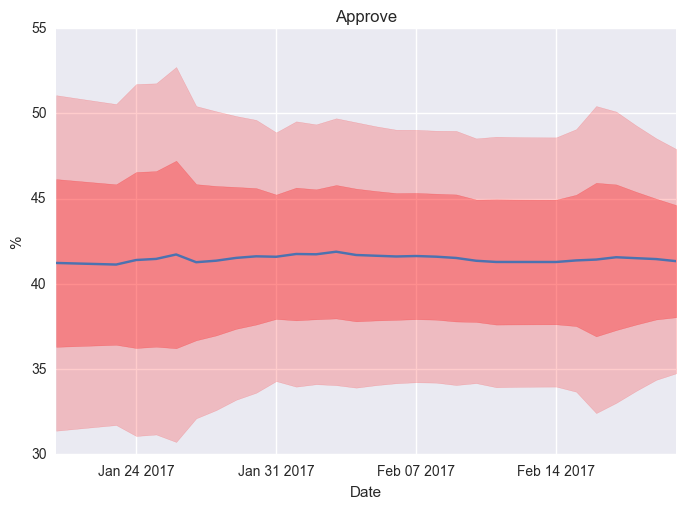

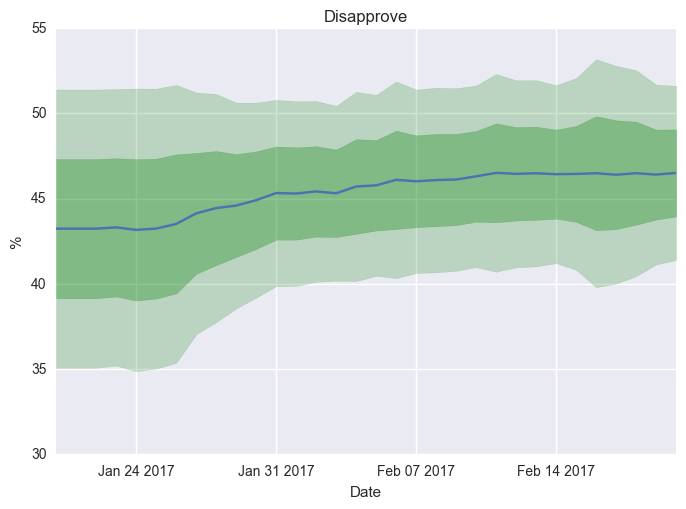

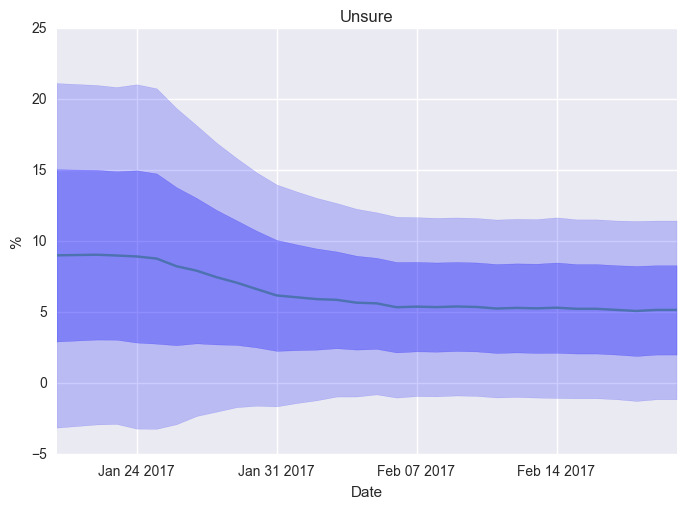

In [307]:
#Plot with mean, one standard deviation band and two standard deviation band
color_list = 'r', 'g', 'b'
for i,df in enumerate(df_list): 
    plt.title(str(df_name_list[i]))
    #mean
    plt.plot(df['MEAN'])
    #bands
    plt.fill_between(df.index, df['MEAN'] + 2*df['STDEV'], df['MEAN'] - 2*df['STDEV'], color = color_list[i], alpha=0.2)
    plt.fill_between(df.index, df['MEAN'] + df['STDEV'], df['MEAN'] - df['STDEV'], color = color_list[i], alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('%')
    plt.show()
    

If we can trust the means, it's fairly clear that Trump's approval rating has not ebbed or flowed much despite all that has happened in his first weeks in office. This goes to show that Trump's base, the one who voted him in, will continue to support him for a number of reasons: first, no one should be surprised that his base approves of his policies thus far. One in two americans approves of a Muslim ban and he campaigned on the promise that he would bring one about. The same can be said of the Wall, withdrawing from the Trans Pacific Partnership, and other deliverables. secondly, the chaos seen surrounding the Trump administration has not been a bug, but a feature, manifest in the campaign promise to "drain the swamp." The populist base that got Mr. Trump into office surely stands to rejoice at the chaos, while the rest of the country is horrified by it. 

What we have found is that while not losing support, it certainly seems as if he's losing ground (if he cares about support from anyone besides his base). Trump is alienating those who don't know whether they support him or not, and surely is sending those who oppose him further into their own trench. We've seen an average of 4% of the sample leave the unsure camp and enter into the disapproves camp. 

All in all, Trump has seen relatively steady results, on average, if we can assume that these polls provide a representative view of the nation's Trump sentiment.